In [12]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu118


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [14]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [15]:
df_train = pd.read_csv("../data/train.csv")
df_test = pd.read_csv("../data/test.csv")

In [16]:
def remove_outliers(df, quantile=0.05):
    Q1 = df.quantile(quantile)
    Q3 = df.quantile(1-quantile)
    IQR = Q3 - Q1
    
    return df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

def apply_feature_engineering(df: pd.DataFrame, keep_outliers) -> pd.DataFrame:
    df["total_bedrooms"] = df["total_bedrooms"].fillna(df["total_bedrooms"].mean())
    custom_encoding = {"ISLAND": 4, "NEAR OCEAN": 3, "NEAR BAY": 2, "<1H OCEAN": 1, "INLAND": 0}
    df["ocean_proximity_enc"] = df.replace({"ocean_proximity": custom_encoding})["ocean_proximity"]
    df = df.drop("ocean_proximity", axis=1)
    df["rooms_per_bedroom"] = df["total_rooms"] / df["total_bedrooms"]
    df["rooms_per_household"] = df["total_rooms"] / df["households"]
    df["encoded_position"] = df["longitude"] + df["latitude"]
    df["population_per_bedrooms"] = df["population"] / df["total_bedrooms"]
    df["target"] = df["median_house_value"]
    df = df.drop("median_house_value", axis=1)
    if not keep_outliers:
        df = remove_outliers(df, 0.05)
    return df

In [17]:
df_train = apply_feature_engineering(df_train, True)
df_test = apply_feature_engineering(df_test, False)

X_train = df_train.drop("target", axis=1)
y_train = df_train["target"]

X_test = df_test.drop("target", axis=1)
y_test = df_test["target"]

/tmp/ipykernel_62527/285434561.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["ocean_proximity_enc"] = df.replace({"ocean_proximity": custom_encoding})["ocean_proximity"]
/tmp/ipykernel_62527/285434561.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["ocean_proximity_enc"] = df.replace({"ocean_proximity": custom_encoding})["ocean_proximity"]


In [18]:
class MLPRegressor(nn.Module):
    def __init__(self, inputs: int, layers: list[int], dropout_rate: int = 0, activation_func="relu"):
        super(MLPRegressor, self).__init__()
        self.layers = nn.ModuleList()
        self.layers_per_dropout = 0 if dropout_rate == 0 else len(layers) // dropout_rate
        count = 0
        for n_nodes in layers:
            self.layers.append(nn.Linear(inputs, n_nodes))
            self.layers.append(nn.ReLU()) if activation_func == "relu" else nn.Sigmoid()
            count += 1
            if self.layers_per_dropout == count:
                self.layers.append(nn.Dropout(dropout_rate))
                count = 0
            inputs = n_nodes
        self.output_layer = nn.Linear(layers[-1], 1)
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.output_layer(x)
        return x

In [19]:
def build_model(inputs: int,
                layers: list[int],
                device: str,
                dropout_rate: int = 0,
                activation_func: str = "relu",
                optimizer: str = "adam"):
    model = MLPRegressor(inputs, layers, dropout_rate, activation_func).to(device)
    criterion = nn.MSELoss()
    if optimizer == "adam":
        optimizer = optim.Adam(model.parameters())
    elif optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    return model, criterion, optimizer

def train_model(model, criterion, optimizer, train_loader, valid_loader, epochs=100, patience=None):
    train_losses = []
    valid_losses = []
    if patience is not None:
        early_stop = EarlyStopping(patience=patience, verbose=True)
        callbacks = [early_stop]
    else:
        callbacks = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        if valid_loader is not None:
            model.eval()
            with torch.no_grad():
                valid_loss = 0.0
                for inputs, labels in valid_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    valid_loss += loss.item()
                valid_loss /= len(valid_loader)
                valid_losses.append(valid_loss)
                print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Valid Loss: {valid_loss:.4f}")
                for callback in callbacks:
                    callback.step(valid_loss, model)
        else:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}")
            for callback in callbacks:
                callback.step(epoch_loss, model)
    return train_losses, valid_losses

class EarlyStopping:
    def __init__(self, patience: int = 5, verbose: bool = False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def step(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).')
        self.val_loss_min = val_loss

In [20]:
pipe = Pipeline([
    ("scaler", StandardScaler())
])

pipe.fit(X_train)

X_train_scaled = torch.tensor(pipe.transform(X_train), dtype=torch.float32)
X_test_scaled = torch.tensor(pipe.transform(X_test), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

model, criterion, optimizer = build_model(X_train_scaled.shape[1], [10, 50, 100], device, 25, "relu", "adam")
train_loader = DataLoader(TensorDataset(X_train_scaled, y_train_tensor), batch_size=100, shuffle=True)
valid_loader = DataLoader(TensorDataset(X_test_scaled, y_test_tensor), batch_size=100, shuffle=False)


In [21]:
def rmse(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred)**2))

def plot_rmse(train_losses, valid_losses):
    epochs = range(1, len(train_losses) + 1)
    fig = plt.figure(figsize=(12, 6), dpi=80)
    plt.plot(epochs, np.sqrt(train_losses), label="Training")
    plt.plot(epochs, np.sqrt(valid_losses), label="Validation")
    plt.legend()
    plt.ylabel("RMSE")
    plt.xlabel("Epoch")
    plt.show()

In [22]:


train_losses, valid_losses = train_model(model, criterion, optimizer, train_loader, valid_loader, epochs=1000, patience=20)

Epoch 1/1000, Train Loss: 56421916638.9677, Valid Loss: 54568614737.1707
Validation loss decreased (inf --> 54568614737.170731).
Epoch 2/1000, Train Loss: 55689530004.6452, Valid Loss: 52564492387.9024
Validation loss decreased (54568614737.170731 --> 52564492387.902435).
Epoch 3/1000, Train Loss: 50268324847.4839, Valid Loss: 42873223517.6585
Validation loss decreased (52564492387.902435 --> 42873223517.658539).
Epoch 4/1000, Train Loss: 35440860457.2903, Valid Loss: 25345400482.3415
Validation loss decreased (42873223517.658539 --> 25345400482.341465).
Epoch 5/1000, Train Loss: 20045159737.8064, Valid Loss: 15740851000.1951
Validation loss decreased (25345400482.341465 --> 15740851000.195122).
Epoch 6/1000, Train Loss: 14471633412.1290, Valid Loss: 13122876278.6341
Validation loss decreased (15740851000.195122 --> 13122876278.634146).
Epoch 7/1000, Train Loss: 12439759492.1290, Valid Loss: 11332487330.3415
Validation loss decreased (13122876278.634146 --> 11332487330.341463).
Epoch 8

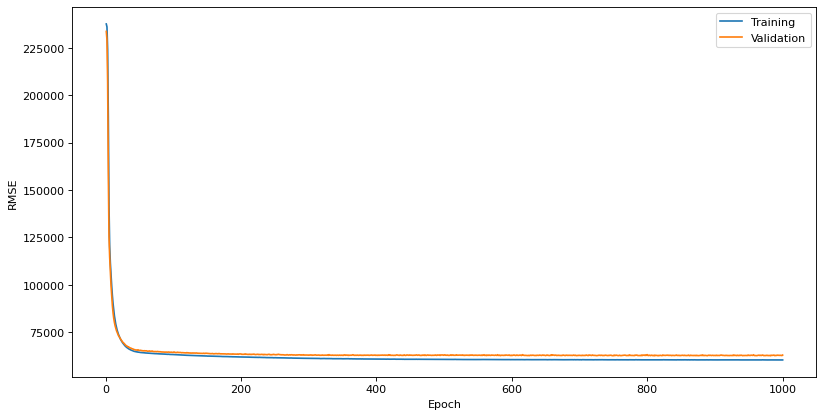

In [23]:
plot_rmse(train_losses, valid_losses)

In [24]:
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_scaled)
    rmse_value = rmse(y_test_tensor, y_pred_tensor)
    print("Root Mean Squared Error:", rmse_value.item())

Root Mean Squared Error: 62900.6875
